In [ ]:
version = "REPLACE_PACKAGE_VERSION"

---
# Assignment 2 Part 2: Time Series Similarities (50 pts)

In this assignment, we're going to explore several techniques for measuring similarity between two time series. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Suppress all warnings
import warnings
warnings.filterwarnings("ignore")

In [221]:
# !pip install fastdtw

  Using cached mlpy-0.1.0.zip (4.5 MB)
  ERROR: Command errored out with exit status 1:
   command: /opt/conda/bin/python3.7 -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-90clbiuw/mlpy_42be456cd96a426b93c6e6f24f9f1405/setup.py'"'"'; __file__='"'"'/tmp/pip-install-90clbiuw/mlpy_42be456cd96a426b93c6e6f24f9f1405/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d /tmp/pip-wheel-mh2_6184
       cwd: /tmp/pip-install-90clbiuw/mlpy_42be456cd96a426b93c6e6f24f9f1405/
  Complete output (178 lines):
  running bdist_wheel
  The [wheel] section is deprecated. Use [bdist_wheel] instead.
  running build
  running build_py
  creating build
  creating build/lib.linux-x86_64-3.7
  creating build/lib.linux-x86_64-3.7/mlpy
  copying mlpy/__init__.py -> build/lib.linux-x86_64-3.7/mlpy
  running egg_info
  writing mlpy.egg-info/PKG-INFO
  w

## Question 1: Load data (5 pts)

We will continue to explore the data we used in Part 1, `assets/time_series_covid19_confirmed_global.csv` from the [Johns Hopkins University CSSE COVID-19 dataset](https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_time_series). This time, we are interested in the number of daily new cases **exclusively from the top 5 countries that have the most cumulative cases as of August 21, 2020**. 

Create a function called `load_data` that reads in the csv file and produces a `pd.DataFrame` that looks like: 

| | ? | ? | ? | ? | ? |
|-: | -: | -: | -: | -: | -: |
|**2020-01-23**|0.0|0.0|0.0|0.0|0.0|
|**2020-01-24**|1.0|0.0|0.0|0.0|0.0|
|**2020-01-25**|0.0|0.0|0.0|0.0|0.0|
|**2020-01-26**|3.0|0.0|0.0|0.0|0.0|
|**2020-01-27**|0.0|0.0|0.0|0.0|0.0|
|**...**|...|...|...|...|...|
|**2020-08-17**|35112.0|19373.0|55018.0|4839.0|2541.0|
|**2020-08-18**|44091.0|47784.0|64572.0|4718.0|2258.0|
|**2020-08-19**|47408.0|49298.0|69672.0|4790.0|3916.0|
|**2020-08-20**|44023.0|45323.0|68900.0|4767.0|3880.0|
|**2020-08-21**|48693.0|30355.0|69876.0|4838.0|3398.0|

where
* the index of the DataFrame is a `pd.DatetimeIndex`; 
* the column names "?" are the top 5 countries with the most cumulative cases as of August 21, 2020, sorted in descending order from left to right;
* the values of the DataFrame are daily new cases; and
* the DataFrame doesn't contain any `NaN` values. 


**This function should return a `pd.DataFrame` of shape `(212, 5)`, whose index is a `pd.DatetimeIndex` and whose column labels are the top 5 countries.**

In [2]:
def load_data():
    daily_new_cases = None
    
    df = pd.read_csv('assets/time_series_covid19_confirmed_global.csv').drop(columns = ['Province/State','Lat','Long'])

    df_T = df.set_index('Country/Region').T.reset_index()
    df_T['index'] = pd.to_datetime(df_T['index'])
    df_T = df_T.set_index('index')

    s = df_T.max()
    df_s = df_T[s.sort_values(ascending=False).index[:5]]

    daily_new_cases = df_s.diff().dropna()
    
    
    # YOUR CODE HERE
    #raise NotImplementedError()
    
    return daily_new_cases

In [ ]:
# def load_data():
#     daily_new_cases = None
    
#     df = pd.read_csv('assets/time_series_covid19_confirmed_global.csv').drop(columns=['Province/State', 'Lat','Long'])

#     df_melt = df.melt(id_vars=['Country/Region'], 
#             var_name="Date", 
#             value_name="Value")

#     df_melt['Date'] = pd.to_datetime(df_melt['Date'])

#     df_bydate = df_melt.groupby(by = 'Date').sum().dropna().sort_values(by=['Date'])
    
#     daily_new_cases = df_bydate.Value.diff().dropna()

#     # YOUR CODE HERE
#     #raise NotImplementedError()
    
#     return daily_new_cases

In [3]:
df = pd.read_csv('assets/time_series_covid19_confirmed_global.csv').drop(columns = ['Province/State','Lat','Long'])

# df_melt = df.melt(id_vars=['Country/Region'], 
#         var_name="Date", 
#         value_name="Value")
df = df.groupby(by = 'Country/Region').sum().reset_index()

df_T = df.set_index('Country/Region').T.reset_index()
df_T['index'] = pd.to_datetime(df_T['index'])
df_T = df_T.set_index('index')

s = df_T.max()
df_s = df_T[s.sort_values(ascending=False).index[:5]]

daily_new_cases = df_s.diff().dropna()

daily_new_cases

Country/Region,US,Brazil,India,Russia,South Africa
index,,,,,
2020-01-23,0.0,0.0,0.0,0.0,0.0
2020-01-24,1.0,0.0,0.0,0.0,0.0
2020-01-25,0.0,0.0,0.0,0.0,0.0
2020-01-26,3.0,0.0,0.0,0.0,0.0
2020-01-27,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...
2020-08-17,35112.0,19373.0,55018.0,4839.0,2541.0
2020-08-18,44091.0,47784.0,64572.0,4718.0,2258.0
2020-08-19,47408.0,49298.0,69672.0,4790.0,3916.0


In [4]:
# Autograder tests

stu_ans = load_data()

assert isinstance(stu_ans, pd.DataFrame), "Q1: Your function should return a pd.DataFrame. "
assert stu_ans.shape == (212, 5), "Q1: The shape of your pd.DataFrame returned is incorrect. "
assert isinstance(stu_ans.index, pd.DatetimeIndex), "Q1: The index of your pd.DataFrame must be a pd.DatetimeIndex. "
assert (("2020-01-23" <= stu_ans.index) & (stu_ans.index <= "2020-08-21")).all(), "Q1: The index of your pd.DataFrame contains an incorrect time range. "
assert not stu_ans.isna().any(axis=None), "Q1: Your pd.DataFrame contains NaN values. "
assert stu_ans.dtypes.apply(lambda x: np.issubdtype(x, np.floating)).all(), "Q1: All columns of your pd.DataFrame should have a float dtype. "


# Some hidden tests


del stu_ans

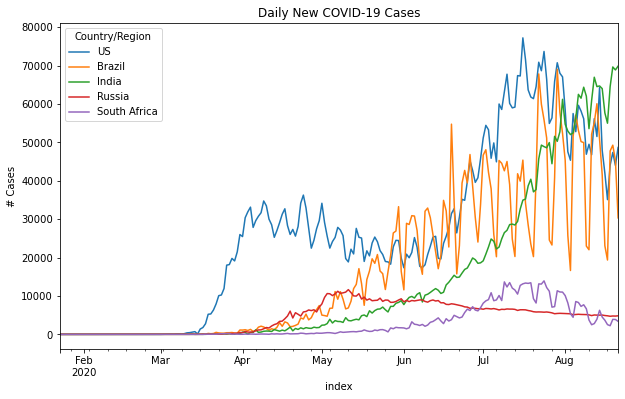

In [5]:
# Let's plot and see the time series
axes = load_data().plot(figsize=(10, 6), title="Daily New COVID-19 Cases", ylabel="# Cases")

del axes

## Question 2: Extract Seasonal Components (5 pts)

Recall from the lectures that an additive Seasonal Decomposition decomposes a time series into the following components:

\begin{equation*}
Y(t) = T(t) + S(t) + R(t)
\end{equation*}

where $T(t)$ represents trends, $S(t)$ represents seasonal patterns and $R(t)$ represents residuals. In the rest of the assignment, we will work with the seasonal component $S(t)$ to understand the similarities among the seasonal patterns of the five time series we have, so let's write a function that extracts this very seasonal component. 

Complete the function below that accepts a `pd.DataFrame` and returns another `pd.DataFrame` of the same shape that looks like:

| | ? | ? | ? | ? | ? |
|-: | -: | -: | -: | -: | -: |
|**2020-01-23**|2431.761670|3380.626554|441.179428|-54.886371|322.986535|
|**2020-01-24**|3446.796153|3457.641332|621.396176|23.689984|362.434811|
|**2020-01-25**|578.564626|586.665963|594.066127|55.034811|391.346141|
|**2020-01-26**|-2728.454422|-6031.950950|46.655454|137.908703|76.880131|
|**2020-01-27**|-3293.854422|-7144.674760|-1234.673118|1.842036|-507.496059|
|**...**|...|...|...|...|...|
|**2020-08-17**|-3293.854422|-7144.674760|-1234.673118|1.842036|-507.496059|
|**2020-08-18**|-719.521088|1549.577621|-544.749308|-28.929392|-662.877011|
|**2020-08-19**|284.707483|4202.114239|76.125240|-134.659770|16.725452|
|**2020-08-20**|2431.761670|3380.626554|441.179428|-54.886371|322.986535|
|**2020-08-21**|3446.796153|3457.641332|621.396176|23.689984|362.434811|

where
* the index of the DataFrame is a `pd.DatetimeIndex`; 
* the column names "?" are the top 5 countries with the most cumulative cases as of August 21, 2020, sorted in descending order from left to right;
* the values of the DataFrame are the seasonal components $S(t)$ as returned by the `seasonal_decompose` function from `statsmodels`; and
* the DataFrame doesn't contain any `NaN` values. 


**This function should return a `pd.DataFrame` of shape `(len(df), 5)`, whose index is a `pd.DatetimeIndex` and whose column labels are the top 5 countries.**

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose

def sea_decomp(df, model="additive"):
    """
    Takes in a DataFrame and extracts the seasonal components
    """
    sea_df = None
    
    stu_df = load_data()
    
    sea_df = stu_df.apply(lambda x: seasonal_decompose(x,model='additive').seasonal)
    
    # YOUR CODE HERE
    #raise NotImplementedError()
    
    return sea_df

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose

stu_df = load_data()
# df_sea = seasonal_decompose(stu_df.values,model='additive',freq=(round(len(stu_df)/2)))
# df_sea

df_sea = stu_df.apply(lambda x: seasonal_decompose(x,model='additive').seasonal)
df_sea

Country/Region,US,Brazil,India,Russia,South Africa
index,,,,,
2020-01-23,2431.761670,3380.626554,441.179428,-54.886371,322.986535
2020-01-24,3446.796153,3457.641332,621.396176,23.689984,362.434811
2020-01-25,578.564626,586.665963,594.066127,55.034811,391.346141
2020-01-26,-2728.454422,-6031.950950,46.655454,137.908703,76.880131
2020-01-27,-3293.854422,-7144.674760,-1234.673118,1.842036,-507.496059
...,...,...,...,...,...
2020-08-17,-3293.854422,-7144.674760,-1234.673118,1.842036,-507.496059
2020-08-18,-719.521088,1549.577621,-544.749308,-28.929392,-662.877011
2020-08-19,284.707483,4202.114239,76.125240,-134.659770,16.725452


In [8]:
# Autograder tests

stu_df = load_data()
stu_ans = sea_decomp(stu_df, "additive")

assert isinstance(stu_ans, pd.DataFrame), "Q2: Your function should return a pd.DataFrame. "
assert stu_ans.shape == (len(stu_df), 5), "Q2: The shape of your pd.DataFrame returned is incorrect. "
assert isinstance(stu_ans.index, pd.DatetimeIndex), "Q2: The index of your pd.DataFrame must be a pd.DatetimeIndex. "
assert (("2020-01-23" <= stu_ans.index) & (stu_ans.index <= "2020-08-21")).all(), "Q2: The index of your pd.DataFrame contains an incorrect time range. "
assert not stu_ans.isna().any(axis=None), "Q2: Your pd.DataFrame contains NaN values. "
assert stu_ans.dtypes.apply(lambda x: np.issubdtype(x, np.floating)).all(), "Q2: All columns of your pd.DataFrame should have a float dtype. "

# Some hidden tests


del stu_df, stu_ans

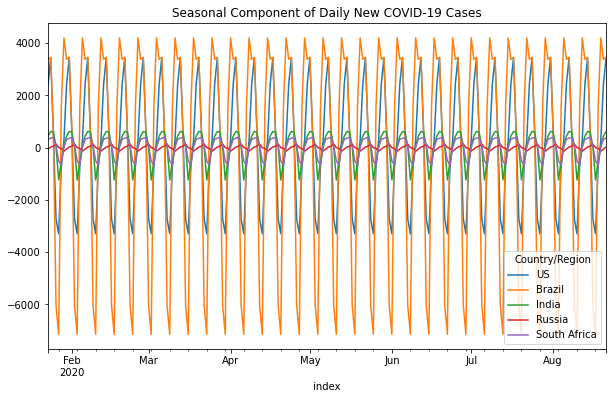

In [9]:
# Let's plot and see the seasonal components

df = load_data()
axes = sea_decomp(df).plot(figsize=(10, 6), title="Seasonal Component of Daily New COVID-19 Cases")

del df, axes

## Question 3: Calculate Euclidean Distance (10 pts)

Now, we may start to ask questions like, "which country in the top 5 countries are the most similar to Country A in terms of seasonal patterns?". In addition to the seasonal components that reflect seasonal patterns, we also need a measure of similarity between two time series in order to answer questions like this. One of such measures is the good old Euclidean Distance. 

Recall that the Euclidean Distance between two vectors $x$ and $y$ is the length of the vector $x - y$:

\begin{equation*}
\mathrm{EucDist}(x, y) = \left\lVert x - y \right\rVert_{2} = \sqrt{\left(x - y\right)^{T}\left(x - y\right)} = \sqrt{\sum_{i = 1}^{n}\left(x_{i} - y_{i}\right)^{2}}
\end{equation*}

Complete the function below that accepts a `pd.DataFrame`, whose columns are time series for each country, and that returns all pairwise Euclidean Distance among these time series, similar to the following:

| | ? | ? | ? | ? | ? |
|-: | -: | -: | -: | -: | -: |
|**?**|0.000000|233760.757213||||
|**?**|233760.757213|0.000000||||
|**?**|||0.000000|||
|**?**||||0.000000||
|**?**|||||0.000000|

where
* the index and the column names "?" are the top 5 countries with the most cumulative cases as of August 21, 2020, sorted in descending order from top to bottom and from left to right; and
* the values of the DataFrame are pairwise Euclidean Distance, for example, `233760.757213` is the Euclidean Distance between the time series of the Rank 1 country and the Rank 2 country

**This function should return a `pd.DataFrame` of shape `(5, 5)`, whose index and column labels are the top 5 countries.**

In [10]:
def calc_euclidean_dist(df):
    """
    Takes in a DataFrame and computes all pairwise Euclidean Distance
    """
    euclidean_dist_df = None
    
    df = load_data()

    df = df.T

    from scipy.spatial.distance import squareform, pdist

    dist_arr = squareform(pdist(df.loc[['US', 'Brazil', 'India','Russia','South Africa']]))
    
    euclidean_dist_df = pd.DataFrame(dist_arr,columns=['US', 'Brazil', 'India','Russia','South Africa'],index=['US', 'Brazil', 'India','Russia','South Africa'])
    
    
    
    
    # YOUR CODE HERE
    #raise NotImplementedError()
    
    return euclidean_dist_df

In [11]:
df = load_data()

df = df.T

from scipy.spatial.distance import squareform, pdist

# test10 = pdist(df.loc[['US','Brazil']])

# test100 = squareform(pdist(df.loc[['US', 'Brazil', 'India','Russia','South Africa']]))

# test100

pairwise = pd.DataFrame(
    squareform(pdist(df)),
    columns = df.index,
    index = df.index
)

pairwise

# hmmm = []
# x = 0
# for column in df:
#     while x < 4:
#         a = df.iloc[:,x].values
#         b = df.iloc[:,x+1].values
#         edist = np.linalg.norm(a-b)
#         x+=1
#         hmmm.append(edist)

# hmmm


# arrays1 = []
# arrays2 = []
# x=0
# for column in df:
#     while x <5:
#         a = df.iloc[:,x].values
#         arrays1.append(a)
#         arrays2.append(b)
#         x+=1

# edist = np.linalg.norm(np.array(arrays1)-np.array(arrays2))
# edist

# np.array(arrays1)

# edistances = []

# for x in np.array(arrays1):
#     for y in np.array(arrays2):
#         edist = np.linalg.norm(x-y)
#         edistances.append(edist)
        
# edistances
        

    
    

Country/Region,US,Brazil,India,Russia,South Africa
Country/Region,,,,,
US,0.000000,233760.757213,272344.138927,433638.331574,436238.175972
Brazil,233760.757213,0.000000,178779.663740,306032.283923,304919.698741
India,272344.138927,178779.663740,0.000000,316862.767630,303936.538967
Russia,433638.331574,306032.283923,316862.767630,0.000000,67392.593681
South Africa,436238.175972,304919.698741,303936.538967,67392.593681,0.000000


In [12]:
df = load_data()
df.T

index,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,2020-01-29,2020-01-30,2020-01-31,2020-02-01,...,2020-08-12,2020-08-13,2020-08-14,2020-08-15,2020-08-16,2020-08-17,2020-08-18,2020-08-19,2020-08-20,2020-08-21
Country/Region,,,,,,,,,,,,,,,,,,,,,
US,0.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,2.0,1.0,...,56203.0,51547.0,64294.0,47913.0,42048.0,35112.0,44091.0,47408.0,44023.0,48693.0
Brazil,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,55155.0,60091.0,50644.0,41576.0,23101.0,19373.0,47784.0,49298.0,45323.0,30355.0
India,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,66999.0,64553.0,64732.0,64030.0,57711.0,55018.0,64572.0,69672.0,68900.0,69876.0
Russia,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,5054.0,5017.0,5016.0,5030.0,4911.0,4839.0,4718.0,4790.0,4767.0,4838.0
South Africa,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2810.0,3946.0,6275.0,4513.0,3692.0,2541.0,2258.0,3916.0,3880.0,3398.0


In [13]:
# Autograder tests

stu_df = load_data()
stu_ans = calc_euclidean_dist(stu_df)

assert isinstance(stu_ans, pd.DataFrame), "Q3: Your function should return a pd.DataFrame. "
assert stu_ans.shape == (5, 5), "Q3: The shape of your pd.DataFrame is not correct. "
assert (stu_ans.index == stu_ans.columns).all(), "Q3: Your pd.DataFrame should have the same index and column labels. "
assert stu_ans.dtypes.apply(lambda x: np.issubdtype(x, np.floating)).all(), "Q3: All columns of your pd.DataFrame should have a float dtype. "

# Some hidden tests


del stu_df, stu_ans

Now let's calculate the pairwise Euclidean Distance between seasonal patterns. What can you say about the similarities among these seasonal patterns? 

In [14]:
# Let's show the pairwise Euclidean Distance matrix

df = load_data()
calc_euclidean_dist(sea_decomp(df))

,US,Brazil,India,Russia,South Africa
US,0.000000,233760.757213,272344.138927,433638.331574,436238.175972
Brazil,233760.757213,0.000000,178779.663740,306032.283923,304919.698741
India,272344.138927,178779.663740,0.000000,316862.767630,303936.538967
Russia,433638.331574,306032.283923,316862.767630,0.000000,67392.593681
South Africa,436238.175972,304919.698741,303936.538967,67392.593681,0.000000


## Question 4: Calculate Cosine Similarity (10 pts)

Another commonly used similarity measure is the Cosine Similarity. Recall that the Cosine Similarity between two vectors $x$ and $y$ is the cosine of the angle between $x$ and $y$:

\begin{equation*}
\mathrm{CosSim}(x, y) = \frac{x^{T}y}{\left\lVert x \right\rVert_{2} \left\lVert y \right\rVert_{2}} = \left(\frac{x}{\left\lVert x \right\rVert_{2}}\right)^{T}\left(\frac{y}{\left\lVert y \right\rVert_{2}}\right)
\end{equation*}

Complete the function below that accepts a `pd.DataFrame`, whose columns are the time series for each country, and that returns all pairwise Cosine Similarity among these time series, similar to the following:

| | ? | ? | ? | ? | ? |
|-: | -: | -: | -: | -: | -: |
|**?**|1.000000	|0.898664||||
|**?**|0.898664|1.000000||||
|**?**|||1.000000|||
|**?**||||1.000000||
|**?**|||||1.000000|

where
* the index and the column names "?" are the top 5 countries with the most cumulative cases as of August 21, 2020, sorted in descending order from top to bottom and from left to right; and
* the values of the DataFrame are pairwise Cosine Similarity, for example, `0.898664` is the Cosine Similarity between the time series of the Rank 1 country and the Rank 2 country

**This function should return a `pd.DataFrame` of shape `(5, 5)`, whose index and column labels are the top 5 countries.**

In [15]:
def calc_cos_sim(df):
    """
    Takes in a DataFrame and computes all pairwise Cosine Similarity
    """
    cos_sim_df = None
    
    from sklearn.metrics.pairwise import cosine_similarity
    df = load_data()
    df = df.T


    cos_sim_df = pd.DataFrame(
        cosine_similarity((df)),
        columns = df.index,
        index = df.index
    )

    # YOUR CODE HERE
    #raise NotImplementedError()
    
    return cos_sim_df

In [16]:
from sklearn.metrics.pairwise import cosine_similarity
df = load_data()
df = df.T
cosine_similarity(df)


cosines = pd.DataFrame(
    cosine_similarity((df)),
    columns = df.index,
    index = df.index
)
cosines

Country/Region,US,Brazil,India,Russia,South Africa
Country/Region,,,,,
US,1.000000,0.898664,0.847160,0.804740,0.884909
Brazil,0.898664,1.000000,0.878452,0.763523,0.871214
India,0.847160,0.878452,1.000000,0.590388,0.809944
Russia,0.804740,0.763523,0.590388,1.000000,0.638246
South Africa,0.884909,0.871214,0.809944,0.638246,1.000000


In [17]:
# Autograder tests

stu_df = load_data()
stu_ans = calc_cos_sim(stu_df)

assert isinstance(stu_ans, pd.DataFrame), "Q4: Your function should return a pd.DataFrame. "
assert stu_ans.shape == (5, 5), "Q4: The shape of your pd.DataFrame is not correct. "
assert (stu_ans.index == stu_ans.columns).all(), "Q4: Your pd.DataFrame should have the same index and column labels. "
assert stu_ans.dtypes.apply(lambda x: np.issubdtype(x, np.floating)).all(), "Q4: All columns of your pd.DataFrame should have a float dtype. "

# Some hidden tests


del stu_df, stu_ans

Now let's calculate the pairwise Cosine Similarity between seasonal patterns. What can you say about the similarities among these seasonal patterns? 

In [18]:
# Let's show the pairwise Cosine Similarity matrix

df = load_data()
calc_cos_sim(sea_decomp(df))

Country/Region,US,Brazil,India,Russia,South Africa
Country/Region,,,,,
US,1.000000,0.898664,0.847160,0.804740,0.884909
Brazil,0.898664,1.000000,0.878452,0.763523,0.871214
India,0.847160,0.878452,1.000000,0.590388,0.809944
Russia,0.804740,0.763523,0.590388,1.000000,0.638246
South Africa,0.884909,0.871214,0.809944,0.638246,1.000000


## Question 5: Calculate Dynamic Time Warping (DTW) Cost (20 pts)

Last but not least, the cost of aligning two time series can also be used as a similarity measure. Two time series are more similar if it incurs less cost to align them. One of the commonly used alignment costs is the Dynamic Time Warping (DTW) cost, which we will explore in this problem. 

### Question 5a (10 pts)

Recall from the lectures that the DTW cost is defined by the following recursive relations:

\begin{align}
&\mathrm{DTW}(1, 1)  = d(x_{1}, y_{1}) \\
&\mathrm{DTW}(i, j)  = d(x_{i}, y_{j}) + \min \begin{cases}
\mathrm{DTW}(i, j - 1) & \text{Repeat } x_{i} \\
\mathrm{DTW}(i - 1, j) & \text{Repeat } y_{j} \\
\mathrm{DTW}(i - 1, j - 1) & \text{Both proceed}
\end{cases}
\end{align}

where we define $d(x_{i}, y_{j}) = (x_{i} - y_{j})^{2}$ as in the lectures. With reference to the demo of the DTW algorithm in the lecture slides, implement the function below that computes the DTW cost for two time series. **We don't take the square root of the results just yet, until later when we compare the DTW costs with the Euclidean Distance.**

**This function should EITHER return a `np.ndarray` of shape `(len(y), len(x))` which represents the DTW cost matrix, OR a single `float` that represents the overall DTW cost, depending whether the parameter `ret_matrix=True`.**

In [107]:
import math


def calc_pairwise_dtw_cost(x, y, ret_matrix=False):
    """
    Takes in two series. If ret_matrix=True, returns the full DTW cost matrix; 
    otherwise, returns only the overall DTW cost
    """

    #dist_fn = lambda a, b: (a - b) ** 2  # Optional helper function 
    
    # YOUR CODE HERE
    #raise NotImplementedError()
      
    len_x = len(x)+1
    len_y = len(y)+1
    
    
    cost_matrix = [[0] * len_y for i in range(len_x)]  
#     for i in range(len_x):
#         cost_matrix[i][0] = i
#     for j in range (len_y):
#         cost_matrix[0][j] = j
    
    
    for j in range(1, len_y):
        for i in range(1, len_x):

            
#             if x[i]==y[j]:
#                 cost_matrix[i][j]=min(
#                     cost_matrix[i-1][j],
#                     cost_matrix[i][j-1],
#                     cost_matrix[i-1][j-1]
#                 )

            cost_matrix[i][j]=((x[i-1]-y[j-1])**2)+min(
            cost_matrix[i-1][j],
            cost_matrix[i][j-1],
            cost_matrix[i-1][j-1]   
            )
            if i == 1:
                cost_matrix[i][j] = ((x[i-1]-y[j-1])**2) + cost_matrix[i][j-1]
            if j == 1:
                cost_matrix[i][j] = ((x[i-1]-y[j-1])**2) + cost_matrix[i-1][j]
            if i ==1 and j == 1:
                cost_matrix[i][j] = (x[i-1]-y[j-1])**2
            
#             else:

    
    dtw_cost = cost_matrix[-1][-1]
    cost_matrix = np.array(cost_matrix)[1:,1:]
    cost_matrix = cost_matrix.T
    
    return cost_matrix if ret_matrix else dtw_cost
#     return (x[1-1]-y[2-1])**2 + cost_matrix[1][1]

In [108]:
x = [1,2,3,4,3,2,1,1,1,2]
y = [0,1,1,2,3,4,3,2,1,1]

calc_pairwise_dtw_cost(x,y,True)

array([[ 1,  5, 14, 30, 39, 43, 44, 45, 46, 50],
       [ 1,  2,  6, 15, 19, 20, 20, 20, 20, 21],
       [ 1,  2,  6, 15, 19, 20, 20, 20, 20, 21],
       [ 2,  1,  2,  6,  7,  7,  8,  9, 10, 10],
       [ 6,  2,  1,  2,  2,  3,  7, 11, 13, 11],
       [15,  6,  2,  1,  2,  6, 12, 16, 20, 15],
       [19,  7,  2,  2,  1,  2,  6, 10, 14, 15],
       [20,  7,  3,  6,  2,  1,  2,  3,  4,  4],
       [20,  8,  7, 12,  6,  2,  1,  1,  1,  2],
       [20,  9, 11, 16, 10,  3,  1,  1,  1,  2]])

In [114]:
# import math
# # from fastdtw import fastdtw
# from scipy.spatial.distance import euclidean

# from scipy.spatial import distance

# df = load_data()

# s1 = np.array(df['US']).astype(np.int32)
# s2 = np.array(df['Brazil']).astype(np.int32)


# # distance, path = fastdtw(s1, s2)
# # distance**2



# def DTW(a, b):   
#     an = a.size
#     bn = b.size
#     pointwise_distance = distance.cdist(a.reshape(-1,1),b.reshape(-1,1))
#     cumdist = np.matrix(np.ones((an+1,bn+1)) * np.inf)
#     cumdist[0,0] = 0

#     for ai in range(an):
#         for bi in range(bn):
#             minimum_cost = np.min([cumdist[ai, bi+1],
#                                    cumdist[ai+1, bi],
#                                    cumdist[ai, bi]])
#             cumdist[ai+1, bi+1] = pointwise_distance[ai,bi] + minimum_cost

#     return cumdist[an, bn]

# test = DTW(s1,s2)
# test





In [115]:
# def dtw(x, y):

   
#     len_x = len(x)
#     len_y = len(y)
    
    
#     dist_mat = [[0] * len_y for i in range(len_x)]  
#     for i in range(len_x):
#         dist_mat[i][0] = i
#     for j in range (len_y):
#         dist_mat[0][j] = j
    
    
#     for j in range(1, len_y):
#         for i in range(1, len_x):
#             if x[i]==y[j]:
#                 dist_mat[i][j]=min(
#                     dist_mat[i-1][j],
#                     dist_mat[i][j-1],
#                     dist_mat[i-1][j-1]
#                 )
#             else:
#                 dist_mat[i][j]=(x[i]-y[j])**2+min(
#                     dist_mat[i-1][j],
#                     dist_mat[i][j-1],
#                     dist_mat[i-1][j-1]   
#                 )
            
#             # YOUR CODE HERE
#             #raise NotImplementedError()
#     return dist_mat

In [109]:
test = calc_pairwise_dtw_cost(s1,s2,True)
test



array([[           0,            1,            1, ..., 244290549417,
        246228573946, 248599582195],
       [           0,            1,            1, ..., 244290549417,
        246228573946, 248599582195],
       [           0,            1,            1, ..., 244290549417,
        246228573946, 248599582195],
       ...,
       [130637415798, 130630502667, 130630601262, ...,   9238001794,
          9262396695,   9249082216],
       [132691590127, 132684586351, 132684676996, ...,   9242349019,
          9239691794,   9251048694],
       [133613016152, 133605951667, 133606012376, ...,   9533153828,
          9426506018,   9575974038]])

In [111]:
# Autograder tests

stu_df = load_data()

# First test with ret_matrix=False
stu_ans = calc_pairwise_dtw_cost(stu_df.iloc[:, 0], stu_df.iloc[:, 1], ret_matrix=False)
assert isinstance(stu_ans, float), "Q5a: Your function should return a float with ret_matrix=False. "
assert np.isclose(stu_ans, 9575974038.0), "Q5a: The DTW cost between Rank 1 and Rank 2 countries is not correct. "

# Then test with ret_matrix=True
stu_ans = calc_pairwise_dtw_cost(stu_df.iloc[:, 0], stu_df.iloc[:, 1], ret_matrix=True)
assert isinstance(stu_ans, np.ndarray), "Q5a: Your function should return a np.ndarray with ret_matrix=True. "
assert stu_ans.shape == (len(stu_df), len(stu_df)), "Q5a: The shape of your np.ndarray is not correct. "
assert np.issubdtype(stu_ans.dtype, np.floating), "Q5a: Your np.ndarray should have a float dtype. "

# Also test with reversing the order of the inputs
stu_ans_T = calc_pairwise_dtw_cost(stu_df.iloc[:, 1], stu_df.iloc[:, 0], ret_matrix=True)
assert np.isclose(stu_ans.T, stu_ans_T).all(), "Q5a: When the order of the inputs is reversed, your new cost matrix should be the old one's transpose. "

# Some hidden tests - for Rank 1 and Rank 2 countries


del stu_df, stu_ans

### Question 5b (10 pts)

Now let's compute all pairwise DTW costs for our five time series. Complete the function below that accepts a `pd.DataFrame`, whose columns are the time series for each country, and that returns all pairwise DTW costs among these time series, similar to the following:

| | ? | ? | ? | ? | ? |
|-: | -: | -: | -: | -: | -: |
|**?**|0.000000e+00		|9.575974e+09||||
|**?**|9.575974e+09|0.000000e+00	||||
|**?**|||0.000000e+00	|||
|**?**||||0.000000e+00	||
|**?**|||||0.000000e+00	|

where
* the index and the column names "?" are the top 5 countries with the most cumulative cases as of August 21, 2020, sorted in descending order from top to bottom and from left to right; and
* the values of the DataFrame are pairwise DTW costs, for example, `9.575974e+09` is the DTW cost between the time series of the Rank 1 country and the Rank 2 country

**This function should return a `pd.DataFrame` of shape `(5, 5)`, whose index and column labels are the top 5 countries.**

In [203]:
def calc_dtw_cost(df):
    """
    Takes in a DataFrame and computes all pairwise DTW costs
    """
    
    dtw_cost_df = None
    
    
    x = []
    y= []


    for column in df:
        add_column = df[[column]].to_numpy()

        x.append(add_column)
        y.append(add_column)

    len_x = len(x)+1
    len_y = len(y)+1 

    final = [[0] * len_y for i in range(len_x)] 

    for i in range(1, len_x):
        for j in range(1, len_y):

                final[i][j] = float(calc_pairwise_dtw_cost(x[i-1],y[j-1]))



    dft = df.T
    df2 = pd.DataFrame(0,columns = df.columns, index = dft.index)



    df_final = pd.DataFrame(final)

    df_final = df_final.iloc[1:,1:]

    names = {1:'US',2:'Brazil',3:'India',4:'Russia',5:'South Africa'}

    df_final = df_final.rename(index = names)
    dtw_cost_df = df_final.rename(columns = names)

    
    
    
    # YOUR CODE HERE
    #raise NotImplementedError()
    
    return dtw_cost_df

In [202]:
df = load_data()
x = []
y= []


for column in df:
    add_column = df[[column]].to_numpy()

    x.append(add_column)
    y.append(add_column)
    
len_x = len(x)+1
len_y = len(y)+1 

final = [[0] * len_y for i in range(len_x)] 
    
for i in range(1, len_x):
    for j in range(1, len_y):
    
            final[i][j] = float(calc_pairwise_dtw_cost(x[i-1],y[j-1]))
        
        
        
dft = df.T
df2 = pd.DataFrame(0,columns = df.columns, index = dft.index)



df_final = pd.DataFrame(final)

df_final = df_final.iloc[1:,1:]

names = {1:'US',2:'Brazil',3:'India',4:'Russia',5:'South Africa'}

df_final = df_final.rename(index = names)
df_final = df_final.rename(columns = names)

# df_final.index[0]



In [201]:
names = {1:'US',2:'Brazil',3:'India',4:'Russia',5:'South Africa'}


# df_final = df_final.rename_axis('index')
df_final = df_final.rename(index = names)
df_final = df_final.rename(columns = names)
df_final
# df_final = df_final.set_axis([df.columns], axis=0, inplace = False).reset_index()

,US,Brazil,India,Russia,South Africa
US,0.000000e+00,9.575974e+09,5.187397e+09,1.740747e+11,1.395159e+11
Brazil,9.575974e+09,0.000000e+00,1.430988e+10,8.361811e+10,6.542703e+10
India,5.187397e+09,1.430988e+10,0.000000e+00,9.927626e+10,8.728950e+10
Russia,1.740747e+11,8.361811e+10,9.927626e+10,0.000000e+00,1.638671e+08
South Africa,1.395159e+11,6.542703e+10,8.728950e+10,1.638671e+08,0.000000e+00


In [204]:
# Autograder tests - takes some time

stu_df = load_data()
stu_ans = calc_dtw_cost(stu_df)

assert isinstance(stu_ans, pd.DataFrame), "Q5b: Your function should return a pd.DataFrame. "
assert stu_ans.shape == (5, 5), "Q5b: The shape of your pd.DataFrame is not correct. "
assert (stu_ans.index == stu_ans.columns).all(), "Q5b: Your pd.DataFrame should have the same index and column labels. "
assert stu_ans.dtypes.apply(lambda x: np.issubdtype(x, np.floating)).all(), "Q5b: All columns of your pd.DataFrame should have a float dtype. "

# Some hidden tests


del stu_df, stu_ans

Now let's calculate the pairwise DTW costs between seasonal patterns. **Take the sqaure root so that we can compare it with the Euclidean Distance**. What can you say about the similarities among these seasonal patterns? 

In [205]:
# Let's show the pairwise DTW costs matrix

df = load_data()
dft = df.T
df2 = pd.DataFrame(0,columns = df.columns, index = dft.index)
df2

seas_df = calc_dtw_cost(sea_decomp(df))

seas_df = np.sqrt(seas_df)
seas_df

,US,Brazil,India,Russia,South Africa
US,0.000000,31878.178988,23565.948799,32327.414867,28016.515162
Brazil,31878.178988,0.000000,53400.789074,61868.013722,57143.198022
India,23565.948799,53400.789074,0.000000,7687.627537,4463.425362
Russia,32327.414867,61868.013722,7687.627537,0.000000,4259.096369
South Africa,28016.515162,57143.198022,4463.425362,4259.096369,0.000000
